# DS-SF-30 | Codealong 18: Natural Language Processing | Answer Key

## >>> One-time setup

In [1]:
'''
import nltk
nltk.download()
'''

pass

## <<< One-time setup

In [2]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

import string
import unicodedata
from nltk import tokenize, corpus, stem

from sklearn import feature_extraction, linear_model, ensemble, cross_validation, metrics, decomposition

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Tokenization

In [3]:
def tokenize_text(document):
    document = document.encode('utf-8')

    # Convert text to lowercase
    document = document.lower()

    # Tokenize
    tokens = tokenize.word_tokenize(document)

    # Remove punctuation in tokens and then remove empty tokens
    tokens = [token.translate(None, string.punctuation) for token in tokens]
    tokens = [token for token in tokens if token]

    # Remove stop words
    tokens = [token for token in tokens if not token in corpus.stopwords.words('english')]

    return tokens

In [4]:
tokens = tokenize_text("This is a sentence...  Wait, here's another.  And a third!")

tokens

['sentence', 'wait', 'another', 'third']

## Stemming

In [5]:
class Stemmer:
    stemmer = stem.porter.PorterStemmer()

    @staticmethod
    def stem_tokens(tokens):
        return [Stemmer.stemmer.stem(token) for token in tokens]

In [6]:
tokens = Stemmer.stem_tokens(tokens)

tokens

[u'sentenc', u'wait', u'anoth', u'third']

## Book reviews

Below, we will be analyzing a partial list of the reviews for J.K. Rowling's The Casual Vacancy.  (https://www.amazon.com/dp/0316228532)

Our dataset is a subset of http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz.

In [7]:
df = pd.read_csv(os.path.join('..', 'datasets', 'dataset-18-reviews.csv'))

In [8]:
df

,date,id,author,title,body,star_rating
0,2016-12-11,R3SH1N77GNTD9K,Stefi,Great read,Very moving story. Great effortless writing wh...,5.0
1,2016-12-11,RVOEQK3JK4LY2,Amazon Customer,Great book! Does not disappoint,Great book! Does not disappoint. Wonderful c...,5.0
2,2016-12-11,RCU7OTNRDJBOS,Priscilla Seaton,Disturbing in its accurate reflection of human...,A very absorbing book. Not at all what I expec...,4.0
3,2016-12-10,R257OLQTPXYQ82,J,Superb,"Lives intertwined, humor,sadness, superior sto...",5.0
4,2016-12-10,R1LNKO30KAXCUM,Roberta L. Sherrill,One Star,Disappointing..... finally quit reading it. S...,1.0
...,...,...,...,...,...,...
5796,2012-09-27,RT2TE0W92SL67,Tricia K.,Seriously? $17 bucks for a computer file??? ...,Premise sounds dull as dirt. For $17 for a co...,1.0
5797,2012-09-27,R14ZGYPSP9H0Y7,Pretzel,A must read,The depth of character development and storyli...,5.0
5798,2012-09-27,R1913ISIDAGQ1A,Prodigy,I love it,The book was great and I will love to re-read ...,5.0
5799,2012-09-27,R2JY771IW7RI3R,David Katz,Kendle price too expensive,I started to order the kindle edition and than...,5.0


In [9]:
df.drop(['date', 'id', 'author', 'title'],
    axis = 1,
    inplace = True)

In [10]:
df

,body,star_rating
0,Very moving story. Great effortless writing wh...,5.0
1,Great book! Does not disappoint. Wonderful c...,5.0
2,A very absorbing book. Not at all what I expec...,4.0
3,"Lives intertwined, humor,sadness, superior sto...",5.0
4,Disappointing..... finally quit reading it. S...,1.0
...,...,...
5796,Premise sounds dull as dirt. For $17 for a co...,1.0
5797,The depth of character development and storyli...,5.0
5798,The book was great and I will love to re-read ...,5.0
5799,I started to order the kindle edition and than...,5.0


### `NaN`

In [11]:
df.isnull().sum()

body           3
star_rating    0
dtype: int64

In [12]:
df.dropna(inplace = True)

In [13]:
df.isnull().sum()

body           0
star_rating    0
dtype: int64

### Positive, neutral, and negatives reviews

In [14]:
df.star_rating.value_counts()

5.0    1497
1.0    1184
4.0    1178
2.0     972
3.0     967
Name: star_rating, dtype: int64

In [15]:
df['polarity'] = df.star_rating.map({1: -1, 2: -1, 3: 0, 4: 1, 5: 1})

In [16]:
ns = df.polarity.value_counts()

ns

 1    2675
-1    2156
 0     967
Name: polarity, dtype: int64

In [17]:
ns.min()

967

In [18]:
for polarity in [-1, 0, 1]:
    n = ns[polarity] - ns.min()
    index = df[df.polarity == polarity].sample(n = n, random_state = 0).index
    df.drop(index, inplace = True)

In [19]:
df.polarity.value_counts()

 1    967
-1    967
 0    967
Name: polarity, dtype: int64

### Feature matrix and response vector

In [20]:
X = df.body
c = df.polarity

In [21]:
X

0       Very moving story. Great effortless writing wh...
3       Lives intertwined, humor,sadness, superior sto...
4       Disappointing..... finally quit reading it.  S...
9       I feel as though JK Rowling was trying a bit t...
10      Very slow reading and depressing. The book doe...
                              ...                        
5784    Thanks a lot, folks. I looked at the reviews t...
5787    excellent character portrayal,insightful,and a...
5793    I'm confused by people who complain about kind...
5795    When I pay more the $10.00 for a book it had b...
5798    The book was great and I will love to re-read ...
Name: body, dtype: object

In [22]:
c

0       1
3       1
4      -1
9       1
10      0
       ..
5784    1
5787    1
5793    1
5795   -1
5798    1
Name: polarity, dtype: int64

### Train/test sets

In [23]:
train_X, test_X, train_c, test_c = cross_validation.train_test_split(X, c, stratify = c, train_size = .6, random_state = 0)

In [24]:
train_c.value_counts()

-1    580
 1    580
 0    580
Name: polarity, dtype: int64

In [25]:
test_c.value_counts()

 0    387
 1    387
-1    387
Name: polarity, dtype: int64

### TF-IDF and `TfidfVectorizer`

In [26]:
'''
vectorizer = feature_extraction.text.TfidfVectorizer(stop_words = 'english')
'''

class CustomTokenizer(object):
    def __call__(self, document):
        tokens = tokenize_text(document)
        tokens = Stemmer.stem_tokens(tokens)
        return tokens

vectorizer = feature_extraction.text.TfidfVectorizer(tokenizer = CustomTokenizer(), ngram_range = (1, 3), min_df = 3)

In [27]:
vectorizer.fit(train_X)

### Bag-of-words

In [28]:
vectorizer.get_feature_names()

[u'1',
 u'1 star',
 u'10',
 u'10 book',
 u'100',
 u'100 page',
 u'12',
 u'13',
 u'14',
 u'15',
 u'16',
 u'1799',
 u'18',
 u'19th',
 u'19th centuri',
 u'2',
 u'20',
 u'200',
 u'200 page',
 u'25',
 u'3',
 u'3 star',
 u'30',
 u'300',
 u'35',
 u'35 star',
 u'4',
 u'40',
 u'400',
 u'400 page',
 u'5',
 u'50',
 u'50 page',
 u'500',
 u'500 page',
 u'503',
 u'503 page',
 u'6',
 u'60',
 u'7',
 u'8',
 u'80',
 u'abandon',
 u'abil',
 u'abl',
 u'abl get',
 u'abl read',
 u'abrupt',
 u'abruptli',
 u'absenc',
 u'absolut',
 u'absolut love',
 u'absolut noth',
 u'absorb',
 u'abus',
 u'abus drug',
 u'accent',
 u'accept',
 u'accomplish',
 u'account',
 u'accur',
 u'achiev',
 u'acquaint',
 u'across',
 u'act',
 u'action',
 u'action one',
 u'actionpack',
 u'actor',
 u'actual',
 u'ad',
 u'add',
 u'addict',
 u'addit',
 u'adjust',
 u'admir',
 u'admit',
 u'admit nt',
 u'admit read',
 u'adolesc',
 u'adolesc charact',
 u'ador',
 u'ador harri',
 u'ador harri potter',
 u'adult',
 u'adult adult',
 u'adult audienc',
 u'a

### Transformed feature matrix `X`

In [29]:
train_X = vectorizer.transform(train_X)
test_X = vectorizer.transform(test_X)

In [30]:
train_X

<1740x4297 sparse matrix of type '<type 'numpy.float64'>'
	with 57804 stored elements in Compressed Sparse Row format>

While dense matrices store every entry in the matrix, sparse matrices only store the nonzero entries.  Sparse matrices don't have a lot of extra features, and some algorithms may not work for them so you use them when you need to work with matrices that would be too big for the computer to handle them, but they are mostly zero, so they compress easily.  You can convert from sparse matrices to dense matrices with `.todense()`

In [31]:
train_X.todense()

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### Machine Learning Modeling

#### Logistic Regression

In [32]:
model = linear_model.LogisticRegression()

In [33]:
cross_validation.cross_val_score(model, train_X, train_c, cv = 5).mean()

0.59252873563218389

In [34]:
train_c_hat = cross_validation.cross_val_predict(model, train_X, train_c, cv = 5)

metrics.accuracy_score(train_c, train_c_hat)

0.59252873563218389

In [35]:
pd.crosstab(train_c_hat, train_c, rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,-1,0,1
Hypothesized Class,,,
-1,385,157,54
0,111,248,128
1,84,175,398


In [36]:
model.fit(train_X, train_c)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
model.score(train_X, train_c)

0.89195402298850579

> # Overfit!

In [38]:
model.score(test_X, test_c)

0.60551248923341949

#### Random Forest

In [39]:
model = ensemble.RandomForestClassifier(n_estimators = 100)

In [40]:
cross_validation.cross_val_score(model, train_X, train_c, cv = 5).mean()

0.58160919540229883

In [41]:
train_c_hat = cross_validation.cross_val_predict(model, train_X, train_c, cv = 5)

metrics.accuracy_score(train_c, train_c_hat)

0.55344827586206902

In [42]:
pd.crosstab(train_c_hat, train_c, rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,-1,0,1
Hypothesized Class,,,
-1,339,158,52
0,121,210,114
1,120,212,414


In [43]:
model.fit(train_X, train_c)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [44]:
model.score(train_X, train_c)

0.99712643678160917

> # Overfit again!

In [45]:
model.score(test_X, test_c)

0.570198105081826

In [46]:
feature_importances = sorted(zip(model.feature_importances_, vectorizer.get_feature_names()), reverse = True)

feature_importances = feature_importances[:50]

feature_importances

[(0.011735094857890977, u'book'),
 (0.011278956036115452, u'disappoint'),
 (0.0093455928398870798, u'bore'),
 (0.0090330711318405473, u'read'),
 (0.0083996175940120911, u'charact'),
 (0.0081779715057510149, u'rowl'),
 (0.0070543168642211006, u'great'),
 (0.0069109673273074716, u'nt'),
 (0.0066089561696457818, u'get'),
 (0.0060005230766638747, u'harri'),
 (0.005965086390070715, u'finish'),
 (0.005693288783663486, u'stori'),
 (0.0055197831366786331, u'good'),
 (0.0052553519622684126, u'ok'),
 (0.005241280461991891, u'could'),
 (0.0049561910474596746, u'mani'),
 (0.004954481672497779, u'much'),
 (0.0047845938013716541, u'tri'),
 (0.0047661182044818774, u'harri potter'),
 (0.0047360500188813395, u'potter'),
 (0.0046877726273954565, u'love'),
 (0.0046086386122465434, u'would'),
 (0.0045855066132602026, u'hard'),
 (0.0045824350279690656, u'jk rowl'),
 (0.004508464276405371, u'interest'),
 (0.0044631350069975918, u'review'),
 (0.0044622142821378391, u'live'),
 (0.00444843649257479, u'well'),


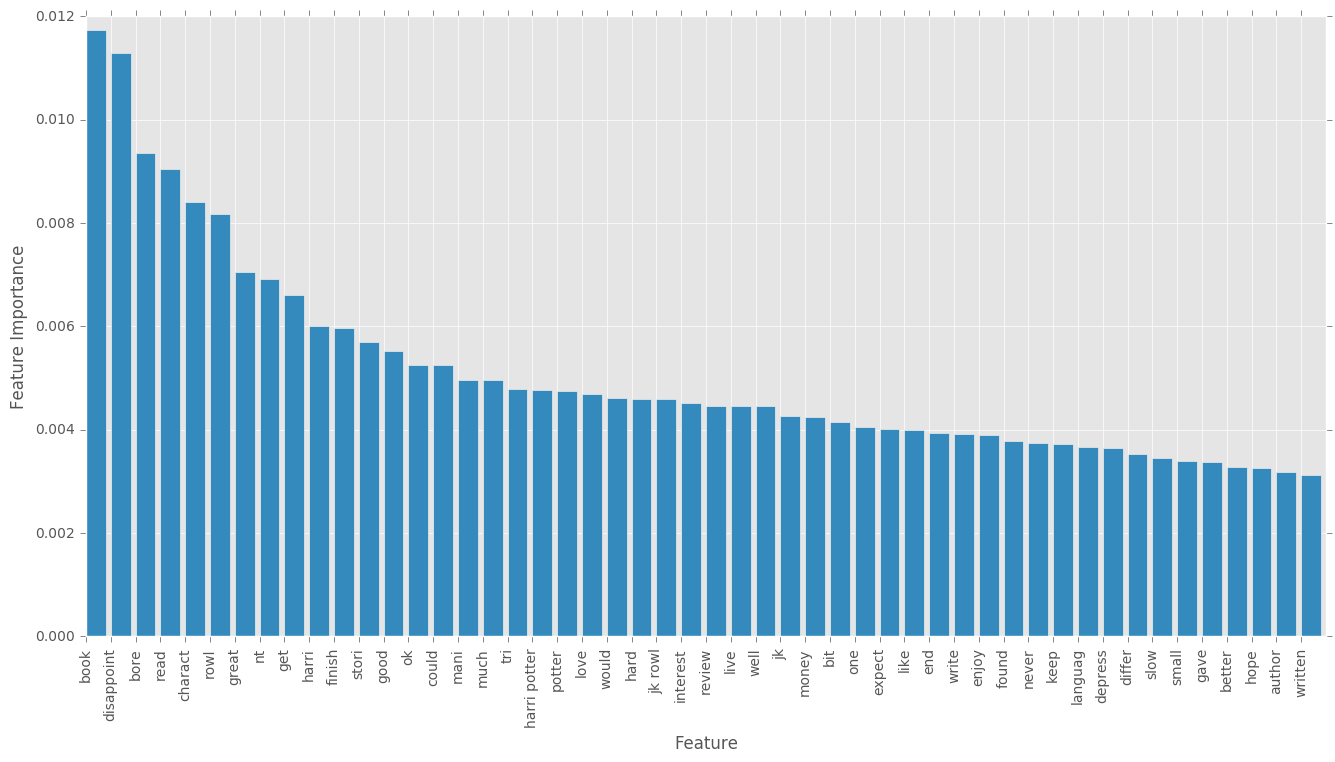

In [47]:
plt.figure(figsize = (16, 8))

plt.bar(
    range(len(feature_importances)),
    [feature_importance[0] for feature_importance in feature_importances]
)

plt.xticks(
    range(len(feature_importances)),
    [feature_importance[1] for feature_importance in feature_importances],
    rotation = 90
)

plt.xlabel('Feature')
plt.ylabel('Feature Importance')

### PCA

In [48]:
pca = decomposition.PCA().fit(train_X.todense())

In [49]:
normalized_eigenvalues = pca.explained_variance_ratio_

In [50]:
normalized_eigenvalues = normalized_eigenvalues[:50]

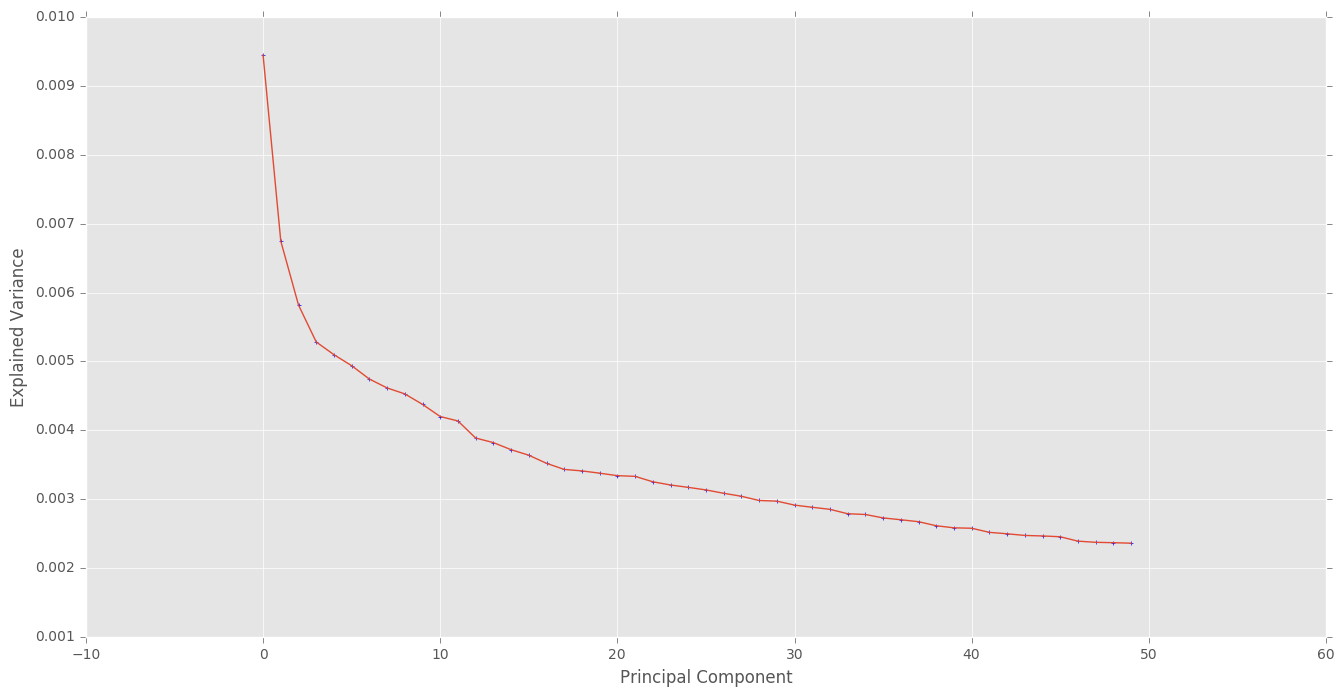

In [51]:
plt.figure(figsize = (16, 8))

plt.plot(normalized_eigenvalues)

plt.scatter(x = range(len(normalized_eigenvalues)),
    y = normalized_eigenvalues,
    marker = '+',
    s = 10)

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')

In [52]:
cumulated_normalized_eigenvalues = np.cumsum(normalized_eigenvalues)

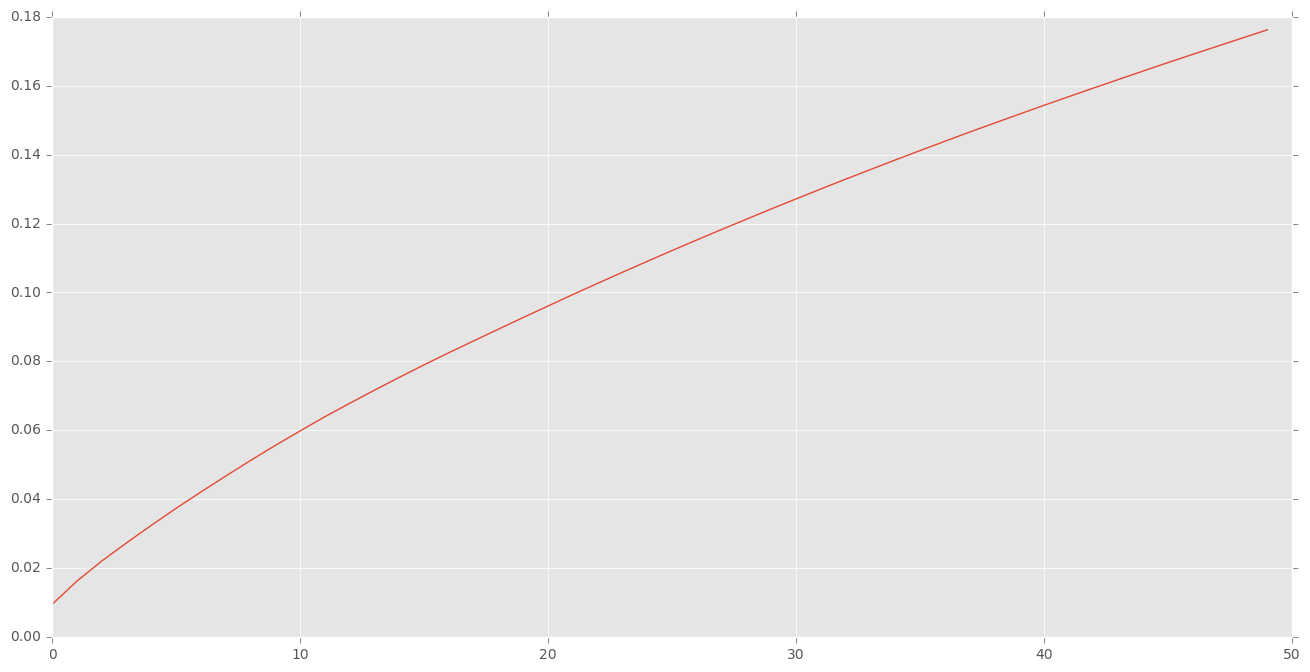

In [53]:
plt.figure(figsize = (16, 8))
plt.plot(cumulated_normalized_eigenvalues)

In [54]:
def interpret(v):
    tokens = pd.Series(vectorizer.get_feature_names())

    v = pd.Series(v).\
        sort_values(ascending = False)

    for token in tokens[v.head(5).index]:
        print '+ {}'.format(token)

    print

    for token in tokens[v.tail(5).index]:
        print '- {}'.format(token)

In [55]:
for i in range(7):
    print 'component {}'.format(i)
    interpret(pca.components_[i])
    print "===\n"

component 0
+ charact
+ stori
+ good
+ mani
+ mani charact

- potter book
- book
- harri
- harri potter
- potter
===

component 1
+ rowl
+ vacanc
+ casual
+ casual vacanc
+ jk rowl

- finish
- get
- read
- book
- nt
===

component 2
+ stori
+ potter
+ harri potter
+ good
+ harri

- jk
- rowl
- nt
- book
- read
===

component 3
+ read
+ good
+ book
+ ok
+ disappoint

- could
- like
- stori
- charact
- nt
===

component 4
+ well
+ good
+ well written
+ written
+ like

- hard
- get
- casual vacanc
- casual
- vacanc
===

component 5
+ good
+ jk
+ jk rowl
+ rowl
+ write

- town
- well written
- well
- charact
- read
===

component 6
+ good
+ mani
+ book
+ charact
+ mani charact

- expect
- disappoint
- well written
- written
- well
===

